<a href="https://colab.research.google.com/github/mbellezi/houseprices/blob/master/HousePrices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```



In [0]:
import functools

import numpy as np
import tensorflow as tf
import os
import pandas as pd
import matplotlib.pyplot as plt


np.set_printoptions(precision=3, suppress=True)

TRAIN_DATA_PATH = '/content/train.csv'
TEST_DATA_PATH = '/content/test.csv'


Dowbload kaggle data locally



In [3]:
!pip install kaggle

os.environ['KAGGLE_USERNAME'] = "mbellezi"
os.environ['KAGGLE_KEY'] = "xxx"
!kaggle competitions download -c house-prices-advanced-regression-techniques


  0% 0.00/450k [00:00<?, ?B/s]
100% 450k/450k [00:00<00:00, 60.6MB/s]
  0% 0.00/13.1k [00:00<?, ?B/s]
100% 13.1k/13.1k [00:00<00:00, 12.7MB/s]
  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 60.0MB/s]
  0% 0.00/31.2k [00:00<?, ?B/s]
100% 31.2k/31.2k [00:00<00:00, 31.3MB/s]


Define target column and feature columns

Load the data from CSV fo Pandas Dataframe

In [0]:
raw_data = pd.read_csv(TRAIN_DATA_PATH)
raw_test_data = pd.read_csv(TEST_DATA_PATH)

Define colums

In [0]:
TARGET_COLUMN = 'SalePrice'

NUMERIC_FEATURES = []
CATEGORICAL_FEATURES = []

for column in raw_data.columns:
  if raw_data[column].dtypes==int or raw_data[column].dtypes==float:
    NUMERIC_FEATURES.append(column)
  else:
    CATEGORICAL_FEATURES.append(column)

NUMERIC_FEATURES.remove('Id')
NUMERIC_FEATURES.remove(TARGET_COLUMN)

Remove features with NAN values

In [0]:
for column in NUMERIC_FEATURES:
  if raw_data[column].isnull().sum() > 0:
    NUMERIC_FEATURES.remove(column)

for column in CATEGORICAL_FEATURES:
  if raw_data[column].isnull().sum() > 0:
    CATEGORICAL_FEATURES.remove(column)

Show features

In [0]:
print( len(NUMERIC_FEATURES), 'numeric columns: ', NUMERIC_FEATURES)
print( len(CATEGORICAL_FEATURES), 'categorical columns: ', CATEGORICAL_FEATURES)
print( 'ID and SalePrice are seperated')

33 numeric columns:  ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
32 categorical columns:  ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtCond', 'BsmtFinType1', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'GarageType', 'GarageQual', 'PavedDrive', 'Fence', 'SaleType', 'SaleCondition']
ID and SalePrice are seperated


Separete train and dev sets

In [0]:
dev_size = 200
raw_data = raw_data.sample(frac=1)
raw_train_data = raw_data.head(raw_data.shape[0] - dev_size)
raw_dev_data = raw_data.tail(dev_size)

print('Train set size: ', raw_train_data.shape[0])
print('Dev set size: ', raw_dev_data.shape[0])

Train set size:  1260
Dev set size:  200


Normalize the numerical data and cast types


In [0]:
DESC = raw_train_data[NUMERIC_FEATURES].describe()

price_mean = raw_train_data[TARGET_COLUMN].mean()
price_sdt = raw_train_data[TARGET_COLUMN].std()

def clean_and_normalize(dataframe, num_features, cat_features, target):

  for feature in num_features:
      dataframe[feature] = np.nan_to_num(dataframe[feature])

  res = dataframe[num_features + cat_features + [target]].copy()

  for feature in num_features:
      res[feature] = tf.cast((res[feature] - DESC[feature]['mean']) / DESC[feature]['std'], tf.float32)

  for feature in cat_features:
      res[feature] = res[feature].astype(str)

  res[target] = tf.cast((res[target] - res[target].mean()) / res[target].std() , tf.float32)

  return res

In [0]:
train = clean_and_normalize(raw_train_data, NUMERIC_FEATURES, CATEGORICAL_FEATURES, TARGET_COLUMN)
dev = clean_and_normalize(raw_dev_data, NUMERIC_FEATURES, CATEGORICAL_FEATURES, TARGET_COLUMN)

print(train[NUMERIC_FEATURES])
print(train[CATEGORICAL_FEATURES])
print(train[TARGET_COLUMN])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


      MSSubClass   LotArea  OverallQual  ...   MiscVal    MoSold    YrSold
1188    0.086912 -0.157696     0.625620  ... -0.104114  0.250745  0.892668
1335   -0.867415 -0.089767    -0.087757  ... -0.104114 -0.861714  0.892668
385     1.518402 -0.704261     1.338997  ... -0.104114 -0.861714  1.641013
251     1.518402 -0.555293     1.338997  ... -0.104114  2.104843 -0.604021
789     0.086912  0.152971    -0.087757  ... -0.104114  0.250745 -0.604021
...          ...       ...          ...  ...       ...       ...       ...
183    -0.151670  0.078962     0.625620  ... -0.104114 -0.120075  0.144324
962     2.472728 -0.787295    -0.087757  ... -0.104114  0.250745 -0.604021
1410    0.086912  0.173397     0.625620  ... -0.104114 -0.120075  0.892668
270     0.086912  0.012648     1.338997  ... -0.104114  0.621564 -1.352365
851     1.518402 -0.702931     1.338997  ... -0.104114 -0.490895 -1.352365

[1260 rows x 33 columns]
     MSZoning Street LotShape  ... Fence SaleType SaleCondition
1188      

Create the final train data casting types and concatenate numerical and cathegorical data

In [0]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, target, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop(target)
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

batch_size=64

train_dataset = df_to_dataset(train, TARGET_COLUMN, shuffle=True, batch_size=batch_size)
dev_dataset = df_to_dataset(dev, TARGET_COLUMN, shuffle=False, batch_size=batch_size)


In [0]:
for feature_batch, label_batch in train_dataset.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of LandContour:', feature_batch['LandContour'])
  print('A batch of targets:', label_batch )

Every feature: ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtCond', 'BsmtFinType1', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'GarageType', 'GarageQual', 'PavedDrive', 'Fence', 'SaleType', 'SaleCondition']
A batch of LandContour: tf.Tensor(
[b'Lvl' b'Lvl' b'Lvl' b'Lvl' b'Lvl' b'Lvl' b'Lvl' b'Lvl' b'Lvl' b

In [0]:
example_batch = next(iter(train_dataset))[0]

# A utility method to create a feature column
# and to transform a batch of data
def demo(feature_column):
  feature_layer = tf.keras.layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())

LandContour = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('LandContour',train['LandContour'].unique()))
demo(LandContour)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [0]:
feature_columns = []

for col in NUMERIC_FEATURES:
  col = tf.feature_column.numeric_column(col)
  feature_columns.append(col)

for col in CATEGORICAL_FEATURES:
  col = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(col,train[col].unique()))
  feature_columns.append(col)

feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [0]:
def build_model():  
  model = tf.keras.Sequential([
    feature_layer,
    tf.keras.layers.Dense(300, kernel_initializer=tf.keras.initializers.glorot_normal, activation='relu'),
    tf.keras.layers.Dense(150, kernel_initializer=tf.keras.initializers.glorot_normal, activation='relu'),
    tf.keras.layers.Dense(75, kernel_initializer=tf.keras.initializers.glorot_normal, activation='relu'),
    tf.keras.layers.Dense(37, kernel_initializer=tf.keras.initializers.glorot_normal, activation='relu'),
    tf.keras.layers.Dense(1, kernel_initializer='zeros'),
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999),
                  loss='mean_squared_error',
                  metrics=['mean_squared_error'])
  return model

model = build_model()

In [0]:
history = model.fit(train_dataset, validation_data=dev_dataset, epochs=400)

Epoch 1/400
20/20 [==============================] - 1s 68ms/step - loss: 0.9950 - mean_squared_error: 0.9969 - val_loss: 1.2181 - val_mean_squared_error: 0.9884
Epoch 2/400
20/20 [==============================] - 0s 10ms/step - loss: 0.9737 - mean_squared_error: 0.9791 - val_loss: 1.1769 - val_mean_squared_error: 0.9547
Epoch 3/400
20/20 [==============================] - 0s 11ms/step - loss: 0.9149 - mean_squared_error: 0.9098 - val_loss: 1.0567 - val_mean_squared_error: 0.8560
Epoch 4/400
20/20 [==============================] - 0s 12ms/step - loss: 0.7437 - mean_squared_error: 0.7499 - val_loss: 0.7849 - val_mean_squared_error: 0.6354
Epoch 5/400
20/20 [==============================] - 0s 10ms/step - loss: 0.4816 - mean_squared_error: 0.4843 - val_loss: 0.4331 - val_mean_squared_error: 0.3600
Epoch 6/400
20/20 [==============================] - 0s 10ms/step - loss: 0.2585 - mean_squared_error: 0.2594 - val_loss: 0.2475 - val_mean_squared_error: 0.2315
Epoch 7/400
20/20 [=========

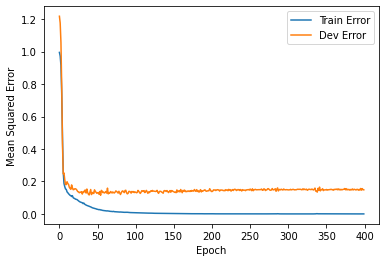

In [0]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Squared Error')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],
           label='Dev Error')
  plt.legend()
  plt.show()

plot_history(history)


In [0]:
def calculate_price(price):
  return price * price_sdt + price_mean

print(calculate_price(0.1485))

194637.3949122763
